In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
import os
import csv
import base64
import requests
import json
import math
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.colors as mcolors

In [2]:
# MASK DETECTION

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
    
def get_main_mask(masks, scores):
    sorted_masks = sorted(zip(masks, scores), key=lambda x: x[1], reverse=True)
    main_mask = sorted_masks[0][0]
    main_mask_score = sorted_masks[0][1]
    return main_mask, main_mask_score 

def get_bounding_box(main_mask, new_image):

    boundingBox = {
        "topLeft": None,
        "bottomRight": [0,0],
    }

    topLeft = False

    for i in range(len(new_image)):
        for j in range(len(new_image[0])):
            if not main_mask[i][j]:
                new_image[i][j] = [0, 0, 0]
            else:
                if not topLeft:
                    boundingBox["topLeft"] = [j, i]
                    topLeft = True
                boundingBox["bottomRight"] = [max(boundingBox["bottomRight"][0], j), max(boundingBox["bottomRight"][1], i)]
    
    return new_image, boundingBox

In [3]:
## METADATA EXTRACTION

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    return encoded_string

def ask_gpt(image_name):
    answers = None
    
    # Encode the image
    encoded_image = encode_image(image_name)

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {API_KEY}"
    }

    payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": "Based on the plot: 1. Describe the title of the x-axis? 2. Describe the range of the x-axis? 3. Describe the title of the y-axis 4. Describe the range of the y-axis? 5. Describe the different types? Please provide the answers to the aforementioned questions only in the following string format: { \"x-axis\": { \"title\": [INSERT TITLE HERE IN STRING FORMAT], \"range\":  INSERT RANGE HERE IN [start, end] FORMAT ],}, \"y-axis\": { \"title\": [INSERT TITLE HERE IN STRING FORMAT], \"range\":  INSERT RANGE HERE IN [start, end] FORMAT, }, \"types\": [INSERT THE TYPES IN LIST OF LISTS OF LENGTH = 2 WHERE EACH LIST LOOKS LIKE [TYPE NAME, MARKER COLOR in \"black\", \"white\", \"red\",\"purple\",\"green\", \"yellow\", \"blue\", \"pink\", \"orange\", \"grey\"]]}"
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encoded_image}"
            }
            }
        ]
        }
    ],
    "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    # Check if the response is successful
    if response.status_code == 200:
        # Parse the response as JSON
        answers = response.json()
    else:
        # Handle errors (non-200 responses)
        print(f"Error: {response.status_code} - {response.text}")

    return answers

In [4]:
## GRAPH RECONSTRUCTION

def get_middle_coordinate(top_left_x, top_left_y, wBox, hbox):
    '''
    Get the center of the box
    '''
    return top_left_x + wBox // 2, top_left_y + hbox // 2

def convertPoint(point, boundingBox, width, height, x_axis, y_axis):

    b_width = boundingBox["bottomRight"][0] - boundingBox["topLeft"][0]
    b_height = boundingBox["bottomRight"][1] - boundingBox["topLeft"][1]
    point_x, point_y = point

    x = (point_x - boundingBox["topLeft"][0]) / b_width
    y = (boundingBox["bottomRight"][1] - point_y) / b_height

    x *= (x_axis[1] - x_axis[0])
    x += x_axis[0]

    y *= (y_axis[1] - y_axis[0])
    y += y_axis[0]
    
    return [x, y]

def get_filtered_answer(mask, x0, y0, wBox, hBox, max_x, max_y):
    for x in range(x0, x0 + wBox + 1):
        for y in range(y0, y0 + hBox + 1):
            if x <= max_x and y <= max_y and mask[x, y] == 1: 
                return True
    return False

In [5]:
## COLOR DETECTION
# basic
colors = {
    "black": (0, 0, 0),
    "grey": (128, 128, 128),
    "white": (255, 255, 255),
    "red": (255, 0, 0),
    "purple": (255, 0, 255),
    "green": (0, 255, 0),
    "yellow": (255, 255, 0),
    "blue": (0, 0, 255),
    "pink": (255,20,147),
    "orange": (255, 165, 0),
}

def get_norm_colors(graph_colors, onlyColorsInImage):
    
    final_colors_rgb = []
    final_colors_labels = []
    for c, rgb in colors.items():
        r, g, b = rgb
        if (onlyColorsInImage and c in graph_colors + ["white", "black"]) or not onlyColorsInImage:
            final_colors_rgb.append([r + .01, g + .01, b + .01])
            final_colors_labels.append(c)
    final_colors_rgb = np.array(final_colors_rgb)
    final_colors_labels = np.array(final_colors_labels)
    norm_colors_rgb = final_colors_rgb / np.linalg.norm(final_colors_rgb, axis=1, keepdims=True)
    
    return norm_colors_rgb, final_colors_labels

def predict_color(input_pixel, colors, labels):
    '''
    Function to predict the label of a new color
    '''
    # Normalize the new color
    norm_new_color = input_pixel / np.linalg.norm(input_pixel)
    norm_new_color = norm_new_color.reshape(1, -1)
    
    # Calculate cosine similarities
    similarities = cosine_similarity(norm_new_color, colors)[0]
    
    # Find the index of the most similar color
    most_similar_index = np.argmax(similarities)
    
    # Return the label of the most similar color
    return labels[most_similar_index]

def is_gray_pixel(pixel, tolerance=10):
    """
    Check if a pixel is gray.
    
    Args:
    pixel (tuple): A tuple representing the RGB values of the pixel (R, G, B).
    tolerance (int): The tolerance level for considering a pixel as gray.
    
    Returns:
    bool: True if the pixel is gray, False otherwise.
    """
    maximum = 255
    r, g, b = pixel
    R = r/maximum
    G = g/maximum
    B = b/maximum
    Cmax = max(R, G, B) 
    Cmin = min(R, G, B) 
    delta = Cmax - Cmin
    return delta == tolerance

def distance(a,b):
    dx = a[0]-b[0]
    dy = a[1]-b[1]
    dz = a[2]-b[2]
    dist = math.sqrt(dx*dx+dy*dy+dz*dz)
    return dist

def get_nearest_color(input_pixel):
    mn = 999999
    color = ''
    p1, p2, p3 = input_pixel
    for name in colors:
        rgb = colors[name]
        d = distance((p1, p2, p3), rgb)
        if d < mn:
            mn = d
            color = name
    return color

def get_nearest_color_within_colors(input_pixel, graph_colors):
    mn = 999999
    color = ''
    p1, p2, p3 = input_pixel
    for name in graph_colors + ["white", "black"]:
        if name in colors:
            rgb = colors[name]
            d = distance((p1, p2, p3), rgb)
            if d < mn:
                mn = d
                color = name
    return color


def get_points(boundingBox, image, color, rgb_colors, norm_colors, labels, wBox, hBox, x_axis, y_axis, onlyColorsInImage, distance_type):

    graph = []
    
    width, height = image.size
    mask = np.zeros((width, height))

    for y in range(0, height):
        for x in range(0, width):

            r, g, b = image.getpixel((x, y))

            if (color == "gray" or color == "grey") and is_gray_pixel([r, g, b], tolerance=10):
                new_color = color
            elif distance_type == "euclidean":
                new_color = get_nearest_color_within_colors((r,g,b), rgb_colors) if onlyColorsInImage else get_nearest_color((r,g,b)) 
            else:
                new_color = predict_color(np.array([r + .01, g + .01, b + .01]), norm_colors, labels)

            if new_color == color:
                mask[x, y] = 1

    for x0 in range(boundingBox["topLeft"][0], boundingBox["bottomRight"][0], wBox):
        for y0 in range(boundingBox["topLeft"][1], boundingBox["bottomRight"][1], hBox):
            
            x, y = get_middle_coordinate(x0, y0, wBox, hBox)
            value = get_filtered_answer(mask, x0, y0, wBox, hBox, boundingBox["bottomRight"][0], boundingBox["bottomRight"][1])

            if value: 
                graph.append({
                "topLeft": (x0, y0), 
                "middle": convertPoint((x,y), boundingBox, width, height, x_axis, y_axis), 
                })
    
    return graph

In [6]:
## HELPER FUNCTION
def is_valid_color(color):
    try:
        mcolors.to_rgba(color)
        return True
    except ValueError:
        return False

In [7]:
def do_analysis(image_number, predictor):
    image_name = '../../plot_images/'+str(image_number)+'.png'
    image = cv2.imread(image_name)

    height, width = image.shape[:2]
    input_point = np.array([[width // 2 - 50, height // 2 - 50], [width // 2 - 50, height // 2 + 50], [width // 2 + 50, height // 2 - 50], [width // 2 + 50, height // 2 + 50]])
    input_label = np.array([1, 1, 1, 1])

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
    main_mask, main_mask_score = get_main_mask(masks, scores)

    n_image = image.copy()
    new_image, boundingBox = get_bounding_box(main_mask, n_image)

    points = np.array([
        boundingBox["topLeft"], 
        [boundingBox["topLeft"][0], boundingBox["bottomRight"][1]], 
        [boundingBox["bottomRight"][0], boundingBox["topLeft"][1]], 
        boundingBox["bottomRight"]
    ])
    
    return image_name, boundingBox

In [8]:
from PIL import Image, ImageEnhance

def alter_image(image_name, filter_type, factor=2):
    image = Image.open(image_name)
    image = image.convert('RGB')
    if filter_type == "Contrast":
        filter = ImageEnhance.Contrast(image)
        image = filter.enhance(factor)
    elif filter_type == "Brightness":
        filter = ImageEnhance.Brightness(image)
        image = filter.enhance(factor)
    elif filter_type == "Sharpness":
        filter = ImageEnhance.Sharpness(image)
        image = filter.enhance(factor)
    return image

In [9]:
def do_complete_analysis(image_number, wBox, hBox, metadata, image_name, boundingBox, onlyColorsInImage = False, distance_type = "euclidean", alter = None):

    x_axis = metadata["x-axis"]["range"]
    y_axis = metadata["y-axis"]["range"]
    x_axis_title = metadata["x-axis"]["title"]
    y_axis_title = metadata["y-axis"]["title"]

    axis_labels = []
    rgb_colors = []
    coordinates = []
    for label, color in metadata["types"]:
        axis_labels.append(label)
        rgb_colors.append(color)
    
    norm_colors_rgb, final_colors_labels = get_norm_colors(rgb_colors, onlyColorsInImage)

    image = alter_image(image_name, alter)

    for color in rgb_colors:
        coordinates.append(get_points(boundingBox, image, color, rgb_colors, norm_colors_rgb, final_colors_labels, wBox, hBox, x_axis, y_axis, onlyColorsInImage, distance_type))

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_axis, y_axis

In [10]:
sam = sam_model_registry["default"](checkpoint="../../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

IMAGE NUMBER 25
Type: cosine
Alter Image: Contrast
IMAGE NUMBER 26
Type: cosine
Alter Image: Contrast
IMAGE NUMBER 27
Type: cosine
Alter Image: Contrast
IMAGE NUMBER 28
Type: cosine
Alter Image: Contrast


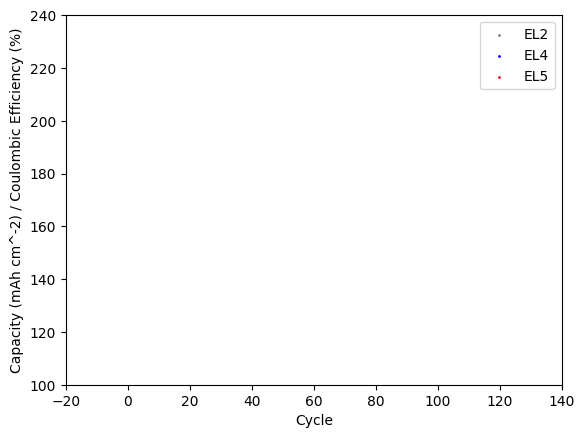

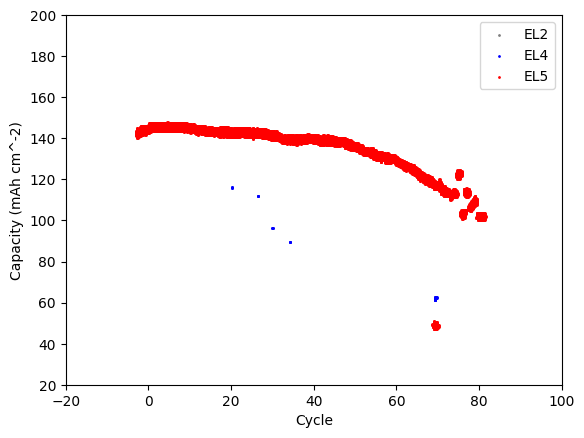

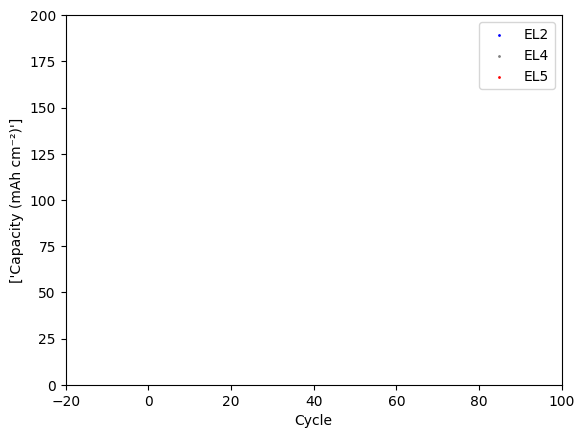

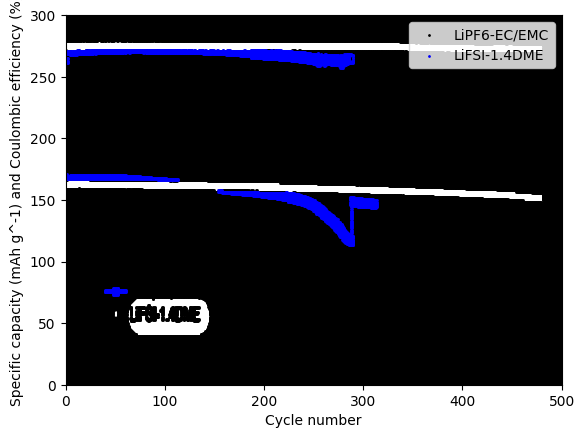

In [11]:
for image_num in range(25, 29):
    print("IMAGE NUMBER", image_num)
    prompt = {}
    with open('../../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    image_name, boundingBox = do_analysis(image_num, predictor)

    for distance_type, onlyColor, alter in [
        # ("euclidean", False, "Contrast"), 
        ("cosine", False, "Contrast")
    ]:
        print("Type:", distance_type)
        print("Alter Image:", alter)
        
        coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range = do_complete_analysis(image_num, 1, 1, prompt, image_name, boundingBox, onlyColor, distance_type, alter)
        
        plt.figure()
        for index, value in enumerate(coordinates):
            x = []
            y = []

            for i in range(len(value)):
                x.append(value[i]["middle"][0])
                y.append(value[i]["middle"][1])

            color_normalized = rgb_colors[index]

            if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

        plt.xlim(x_range[0], x_range[1])
        plt.ylim(y_range[0], y_range[1])
        plt.xlabel(x_axis_title)
        plt.ylabel(y_axis_title)
        plt.legend()
        plt.savefig("../../results/"+distance_type+"/"+str(image_num)+".png")